In [1]:
# Pfad für die Dateien
import os
from models.VAE import VariationalAutoencoder
from models.VAE import CustomCallback
from models.VAE import step_decay_schedule
import matplotlib.pyplot as plt

In [2]:
# Parameter
SECTION = 'vae_sv'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])
RUN_FOLDER = os.path.join("C:\Projekte\dev\git\Masterarbeit", RUN_FOLDER)
if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz_sv'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images_sv'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights_sv'))

mode =  'build' #'load' 

In [3]:
RUN_FOLDER

'C:\\Projekte\\dev\\git\\Masterarbeit\\run/vae_sv/0002_digits'

In [4]:
from models.VAE import VariationalAutoencoder
vae_sv = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2                                  # Dimension des Latent Spaces
)

if mode == 'build':
    RUN_FOLDER = 'run/vae_sv/0002_digits/viz_sv/viz'
    vae_sv.save(RUN_FOLDER)
else:
    vae_sv.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [5]:
vae_sv.encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [6]:
vae_sv.decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0   

In [7]:
from io import StringIO
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

dat = np.loadtxt('HestonTrainSet_ivol_201.txt')     # Trainieren auf den Prices/Impliziten Volatiltäten
NModelPar = 5                                    # Anzahl der Heston Parameter

yy=dat[:len(dat),:NModelPar]                             # Model Parameter für die Trainingsdaten 
xx=dat[:len(dat),NModelPar:]                             # Output Daten (Prices/Impliziten Volatiltäten)
#print(xx.shape)
#print(yy.shape)

strikes=np.array([0.500000000000000, 0.537037037037037, 0.574074074074074, 0.611111111111111, 0.648148148148148, 
                  0.685185185185185, 0.722222222222222, 0.759259259259259, 0.796296296296296, 0.833333333333333,
                  0.870370370370370, 0.907407407407407, 0.944444444444444, 0.981481481481481, 1.01851851851852,
                  1.05555555555556,  1.09259259259259,  1.12962962962963,  1.16666666666667, 1.20370370370370,
                  1.24074074074074, 1.27777777777778, 1.31481481481481, 1.35185185185185,   1.38888888888889,
                  1.42592592592593, 1.46296296296296, 1.50000000000000])                

maturities=np.array([0.500000, 0.851852, 1.203704, 1.555556, 1.907407, 2.259259, 2.611111, 2.962963, 3.314815, 
                     3.666667,4.018519, 4.370370, 4.722222, 5.074074, 5.425926, 5.777778, 6.129630, 6.481481, 
                     6.833333, 7.185185, 7.537037, 7.888889, 8.240741, 8.592593, 8.944444, 9.296296, 9.648148,
                     10.000000])

weights = np.array([0.1,0.1,0.1,1.0,1.0,1.0,1.0,1.0,0.1,0.1,0.1])
cw = np.ndarray.flatten(npm.repmat(weights,8,1))

In [8]:
# Skaling
from sklearn.preprocessing import StandardScaler
scalex = StandardScaler()

xx_transform = scalex.fit_transform(xx)

In [9]:
from sklearn.model_selection import train_test_split
x_train_scaled, x_test_scaled, x_train,x_test,y_train, y_test = train_test_split(
    xx_transform, xx, yy, test_size=0.15, random_state=42) 

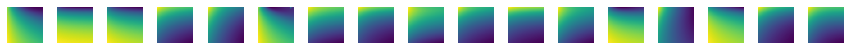

In [10]:
# zufällige Surfaces der Inpudaten ausgeben

n_to_show = 17
example_idx = np.random.choice(range(len(x_test)), n_to_show)
testsurf = np.reshape(xx,(len(xx),28,28,1))
example_surface = testsurf[example_idx]

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_surface[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
          
    sub.imshow(img)

C:\Users\staeding\AppData\Local\Temp/ipykernel_17148/1678104906.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


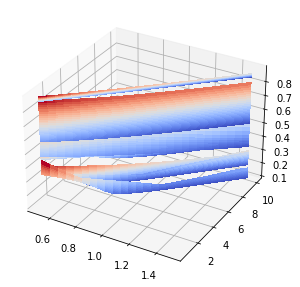

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure(figsize=(5, 5))

ax = fig.gca(projection='3d')
for i in range(n_to_show):
    ax.plot_surface(strikes, maturities, testsurf[i,:,:,0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

sub.imshow(img, cmap='gray_r')

In [13]:
# Reshape für das Nutzen von CNN mit dem Autoencoder
x_train_scaled_reshape = np.reshape(x_train_scaled,(len(x_train),28,28,1))
x_test_scaled_reshape = np.reshape(x_test_scaled,(len(x_test),28,28,1))

x_train_reshape = np.reshape(x_train,(len(x_train),28,28,1))
x_test_reshape = np.reshape(x_test,(len(x_test),28,28,1))

# Kompilieren & Training 

In [14]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 250

In [15]:
vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=1.0, beta=1.0)

#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=0.0, beta=1.0)
#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=0.1, beta=0.9)
#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=0.3, beta=0.7)
#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=0.5, beta=0.5)
#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=0.7, beta=0.3)
#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=0.9, beta=0.1)
#vae_sv.compile(LEARNING_RATE, R_LOSS_FACTOR, alpha=1.0, beta=0.0)

In [16]:
BATCH_SIZE = 32
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [17]:
vae_sv.train(     
    x_train_reshape
    , batch_size = BATCH_SIZE
   , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Train on 8500 samples
Epoch 1/100
  96/8500 [..............................] - ETA: 41s - loss: 6.2910 - vae_r_loss: 6.2870 - vae_kl_loss: 0.0040    

C:\Users\staeding\Anaconda3\lib\site-packages\keras\engine\training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


8480/8500 [============================>.] - ETA: 0s - loss: 3.3011 - vae_r_loss: 2.4458 - vae_kl_loss: 0.8553
Epoch 00001: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-001-3.30.h5

Epoch 00001: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
8500/8500 [==============================] - 14s 2ms/sample - loss: 3.2988 - vae_r_loss: 2.4424 - vae_kl_loss: 0.8565
Epoch 2/100
8500/8500 [==============================] - ETA: 0s - loss: 2.2741 - vae_r_loss: 1.1578 - vae_kl_loss: 1.1163
Epoch 00002: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-002-2.27.h5

Epoch 00002: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
8500/8500 [==============================] - 13s 2ms/sample - loss: 2.2741 - vae_r_loss: 1.1578 - vae_kl_loss: 1.1163
Epoch 3/100
8480/8500 [============================>.] - ETA: 0s - loss: 2.2573 - vae_r_loss: 1.1308 - vae_kl_loss: 1.1265
Epoch 00003: saving model to run/vae_sv/0002_digits/viz_sv/

Epoch 21/100
8480/8500 [============================>.] - ETA: 0s - loss: 2.2199 - vae_r_loss: 1.0685 - vae_kl_loss: 1.1513
Epoch 00021: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-021-2.22.h5

Epoch 00021: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
8500/8500 [==============================] - 14s 2ms/sample - loss: 2.2198 - vae_r_loss: 1.0688 - vae_kl_loss: 1.1510
Epoch 22/100
8480/8500 [============================>.] - ETA: 0s - loss: 2.2107 - vae_r_loss: 1.0457 - vae_kl_loss: 1.1651
Epoch 00022: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-022-2.21.h5

Epoch 00022: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
8500/8500 [==============================] - 13s 2ms/sample - loss: 2.2110 - vae_r_loss: 1.0468 - vae_kl_loss: 1.1642
Epoch 23/100
8480/8500 [============================>.] - ETA: 0s - loss: 2.2224 - vae_r_loss: 1.0818 - vae_kl_loss: 1.1407
Epoch 00023: saving model to run/vae_sv/0002

Epoch 41/100
8500/8500 [==============================] - ETA: 0s - loss: 2.2116 - vae_r_loss: 1.0286 - vae_kl_loss: 1.1830
Epoch 00041: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-041-2.21.h5

Epoch 00041: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
8500/8500 [==============================] - 13s 2ms/sample - loss: 2.2116 - vae_r_loss: 1.0286 - vae_kl_loss: 1.1830
Epoch 42/100
8480/8500 [============================>.] - ETA: 0s - loss: 2.2039 - vae_r_loss: 1.0237 - vae_kl_loss: 1.1802
Epoch 00042: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-042-2.20.h5

Epoch 00042: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
8500/8500 [==============================] - 14s 2ms/sample - loss: 2.2034 - vae_r_loss: 1.0234 - vae_kl_loss: 1.1800
Epoch 43/100
8480/8500 [============================>.] - ETA: 0s - loss: 2.2169 - vae_r_loss: 1.0399 - vae_kl_loss: 1.1770
Epoch 00043: saving model to run/vae_sv/0002

Epoch 61/100
8500/8500 [==============================] - ETA: 0s - loss: 2.1687 - vae_r_loss: 0.9944 - vae_kl_loss: 1.1743
Epoch 00061: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-061-2.17.h5

Epoch 00061: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
8500/8500 [==============================] - 13s 2ms/sample - loss: 2.1687 - vae_r_loss: 0.9944 - vae_kl_loss: 1.1743
Epoch 62/100
8480/8500 [============================>.] - ETA: 0s - loss: 2.1903 - vae_r_loss: 0.9963 - vae_kl_loss: 1.1939
Epoch 00062: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-062-2.19.h5

Epoch 00062: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
8500/8500 [==============================] - 13s 2ms/sample - loss: 2.1917 - vae_r_loss: 0.9977 - vae_kl_loss: 1.1939
Epoch 63/100
8480/8500 [============================>.] - ETA: 0s - loss: 2.1863 - vae_r_loss: 0.9949 - vae_kl_loss: 1.1913
Epoch 00063: saving model to run/vae_sv/0002

8500/8500 [==============================] - 14s 2ms/sample - loss: 2.2100 - vae_r_loss: 1.0083 - vae_kl_loss: 1.2017
Epoch 81/100
8480/8500 [============================>.] - ETA: 0s - loss: 2.2162 - vae_r_loss: 1.0078 - vae_kl_loss: 1.2084
Epoch 00081: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-081-2.22.h5

Epoch 00081: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
8500/8500 [==============================] - 13s 2ms/sample - loss: 2.2164 - vae_r_loss: 1.0082 - vae_kl_loss: 1.2083
Epoch 82/100
8500/8500 [==============================] - ETA: 0s - loss: 2.1958 - vae_r_loss: 0.9998 - vae_kl_loss: 1.1960
Epoch 00082: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-082-2.20.h5

Epoch 00082: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
8500/8500 [==============================] - 15s 2ms/sample - loss: 2.1958 - vae_r_loss: 0.9998 - vae_kl_loss: 1.1960
Epoch 83/100
8480/8500 [==========================

Epoch 00100: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights-100-2.20.h5

Epoch 00100: saving model to run/vae_sv/0002_digits/viz_sv/viz\weights\weights.h5
8500/8500 [==============================] - 13s 2ms/sample - loss: 2.1963 - vae_r_loss: 0.9991 - vae_kl_loss: 1.1972


## Rekonstruktion

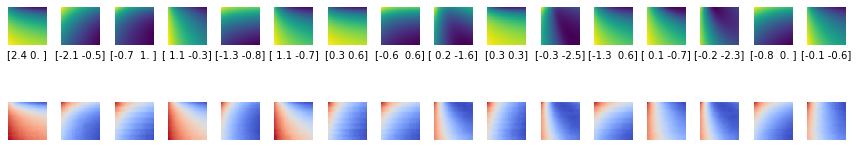

In [27]:
# zufällige Rekonstruktion

n_to_show = 16

example_idx = np.random.choice(range(len(x_test)), n_to_show) # generiere zufällige ID's
#example_idx = [2,39,705,69,81,912,306,1210,1031,341,1314,670,624,352,293,486]  # für Vergleich mit AE

example_surface = x_test[example_idx] # (zufälligen) Surfaces
example_surface = np.reshape(example_surface,(len(example_surface),28,28,1))

z_points = vae_sv.encoder.predict(example_surface) # z_points auf denen die (zufälligen) Surfaces gespeichert sind

reconst_images = vae_sv.decoder.predict(z_points) # vom VAE rekonstruierte Surfaces 

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show): # originale Surfaces
    img = example_surface[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)         
    sub.imshow(img)

for i in range(n_to_show): # rekonstruierte Surfaces
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='coolwarm')
    
#fig.savefig('C:\\Users\\staeding\\Desktop\\Masterarbeit_neu\\VAE_neu\\Rek3D_zufaellig') 

In [28]:
# Rekonstruktion von Surfaces auf einem bestimmten Grid

import pandas as pd

n_to_show = 17

example_surface = x_test                                       # erstmal alle Surfaces abspeichern
example_surface = np.reshape(example_surface,(len(example_surface),28,28,1))

z_points = vae_sv.encoder.predict(example_surface)               # z_points auf denen die alles Surfaces gespeichert sind


df = pd.DataFrame(np.round(z_points,1))                      
df.to_excel('z_points_VAE.xlsx')                     # speicher die z_points gerundet auf eine Nachkommastelle in eine Excel ab

In [29]:
## Grid mit fixer x-Kooridante 
# Kooridanten mit den jeweiligen Indexe extrahiert mit Excel (nicht elegant, aber effektiv)

z_points_grid = np.array([[0.0, -1.0],[0.0, -0.9],[0.0, -0.8],[0.0, -0.6],[0.0, -0.5],[0.0, -0.4],[0.0, -0.3],[0.0, -0.2],
                         [0.0, -0.1],[0.0, 0.0],[0.0, 0.1],[0.0, 0.3],[0.0, 0.5],[0.0, 0.6],[0.0, 0.7],[0.0, 0.9],[0.0, 1.0]])

idx = [1268,583,193,418,1175,1076,872,1147,590,547,859,972,107,898,867,587,1353]

example_surfaces_grid = np.zeros([n_to_show,28,28,1])
for i in range(len(idx)):
    example_surfaces_grid[i] = example_surface[idx[i]]

In [30]:
# Grid mit fixer y-Kooridante 
# Kooridanten mit den jeweiligen Indexe extrahiert mit Excel (nicht elegant, aber effektiv)

z_points_grid = np.array([[-0.9, 0.0],[-0.8, 0.0],[-0.7, 0.0],[-0.5, 0.0],[-0.4, 0.0],[-0.3, 0.0],[-0.2, 0.0],[-0.1, 0.0],
                         [0, 0.0],[0.1, 0.0],[0.2, 0.0],[0.3, 0.0],[0.4, 0.0],[0.5, 0.0],[0.6, 0.0],[0.7, 0.0],[0.9, 0.0]])

idx = [24,209,970,1307,424,1456,1295,681,547,1299,1144,1073,253,1303,1138,1230,351]

example_surfaces_grid = np.zeros([n_to_show,28,28,1])
for i in range(len(idx)):
    example_surfaces_grid[i] = example_surface[idx[i]]

In [31]:
# Grid mit fixer z-Kooridante 
# Kooridanten mit den jeweiligen Indexe extrahiert mit Excel (nicht elegant, aber effektiv)

z_points_grid = np.array([[-1.2, -0.3, 0.0],[-1.1, -0.4, 0.0],[-1.0, 1.7, 0.0],[-0.7, -0.5, 0.0],
                          [-0.6, 1.2, 0.0],[-0.5, -1.8, 0.0],[-0.3, -0.1, 0.0],[-0.1, 0.2, 0.0],[0.0, 1.7, 0.0],
                          [0.1, 0.8, 0.0],[0.2, -2.1, 0.0],[0.3, 0.4, 0.0],[0.4, 0.9, 0.0],[0.8, 1.0, 0.0],
                          [0.9, 0.5, 0.0],[1.0, -0.8, 0.0],[1.5, -0.1, 0.0]])

idx = [1402,945,1119,42,1280,868,1057,958,1437,1265,187,1403,1468,1483,670,891,1430]

example_surfaces_grid = np.zeros([n_to_show,28,28,1])
for i in range(len(idx)): # speichere die Surfaces auf dem Grid ab
    example_surfaces_grid[i] = example_surface[idx[i]]

In [ ]:
# Rekonstruktion auf einem bestimmten Grid

n_to_show = 17

reconst_images = vae_sv.decoder.predict(z_points_grid)                # vom VAE rekonstruierte Surfaces auf dem Grid

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show): # originale Surfaces
    img = example_surfaces_grid[i].squeeze()     
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(z_points_grid[i]), fontsize=10, ha='center', transform=sub.transAxes)         
    sub.imshow(img)
    
    
for i in range(n_to_show): #  rekonstruierte Surfaces
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    c = sub.imshow(img, cmap='coolwarm')#gray_r')
    
#    fig.colorbar(c, ax = sub) 
fig.savefig('Rek_VAE_Fix') 

    epoch      loss      lr  vae_kl_loss  vae_r_loss
0       0  3.298830  0.0005     0.856467    2.442363
1       1  2.274078  0.0005     1.116263    1.157815
2       2  2.257004  0.0005     1.126668    1.130337
3       3  2.253446  0.0005     1.136506    1.116940
4       4  2.248367  0.0005     1.121965    1.126402
..    ...       ...     ...          ...         ...
95     95  2.202953  0.0005     1.214705    0.988247
96     96  2.185986  0.0005     1.188523    0.997462
97     97  2.187357  0.0005     1.188114    0.999244
98     98  2.194896  0.0005     1.195835    0.999061
99     99  2.196343  0.0005     1.197243    0.999100

[100 rows x 5 columns]


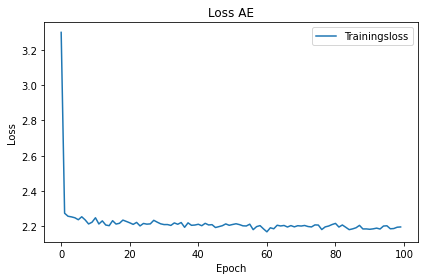

In [32]:
# Plot des gesamten Verlustes

import pandas as pd
df = pd.read_csv('log.csv', sep=';')
print(df)

# Plot
plt.figure()
plt.plot(df['epoch'], df['loss'], ls='-')
plt.title('Loss AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Trainingsloss'])
plt.savefig('LossVAE.png')
plt.tight_layout()

# Analysis starts here

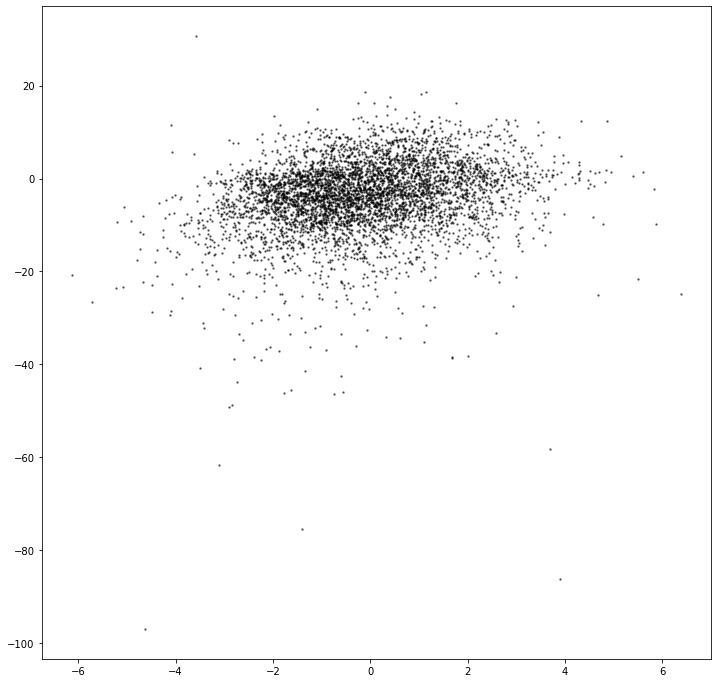

In [33]:
# Gibt den Latent Space mit n_to_show Punkten aus 

n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae_sv.encoder.predict(x_test_scaled_reshape[example_idx])

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])
#min_t = min(z_points[:, 2])          # für 3D
#max_t = max(z_points[:, 2])          # für 3D

# für 2D
plt.figure(figsize=(figsize, figsize))
plot = plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()
fig = plot.get_figure()
fig.savefig('LatentSpace2D.png')


# für 3D
#fig = plt.figure(figsize=(15, 15))
#ax = fig.add_subplot(projection='3d')
#for i in range(n_to_show):
#    ax.scatter(z_points[:, 0], z_points[:, 1], z_points[:, 2], cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False, c='black')
#ax.set_title('Latent Space in 3D')
#ax.set_xlabel('Z1')
#ax.set_ylabel('Z2')
#ax.set_zlabel('Z3')
#sub.imshow(img, cmap='gray_r')
#fig.savefig('LatentSpace3D.png')

C:\Users\staeding\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


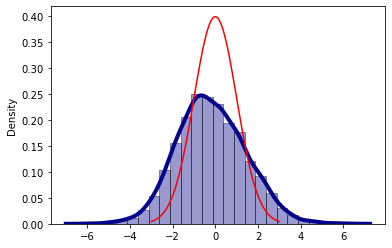

In [34]:
# Gibt Zufallsvariablen/Punkte x des Latent Spaces aus und vergleicht diese mit der Standardnormalverteilung

import seaborn as sns
import scipy.stats as stats
plot = sns.distplot(z_points[:, 0], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
x = np.linspace(0 - 3*1, 0 + 3*1, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1), color='red')
fig = plot.get_figure()
#fig.savefig('LatentSpace1_NormalDist') 

C:\Users\staeding\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


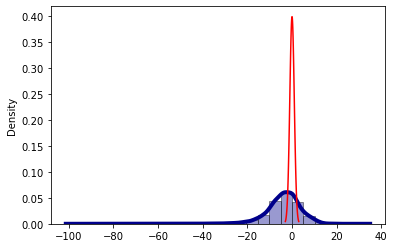

In [35]:
# Gibt Zufallsvariablen/Punkte y des Latent Spaces aus und vergleicht diese mit der Standardnormalverteilung

plot = sns.distplot(z_points[:, 1], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
x = np.linspace(0 - 3*1, 0 + 3*1, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1), color='red')
fig = plot.get_figure()
#fig.savefig('LatentSpace2_NormalDist') 

In [ ]:
# Gibt Zufallsvariablen/Punkte z des Latent Spaces aus und vergleicht diese mit der Standardnormalverteilung

plot = sns.distplot(z_points[:, 2], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
x = np.linspace(0 - 3*1, 0 + 3*1, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1), color='red')
fig = plot.get_figure()
#fig.savefig('LatentSpace3_NormalDist') 

## Weitere Analysen

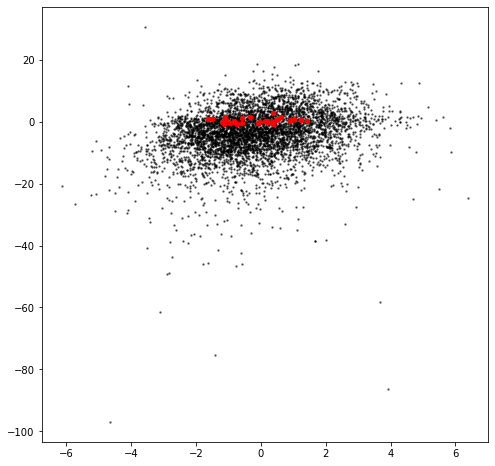

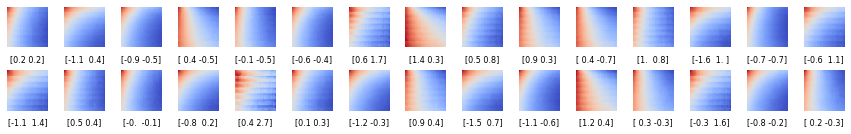

In [37]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = vae_sv.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'coolwarm')


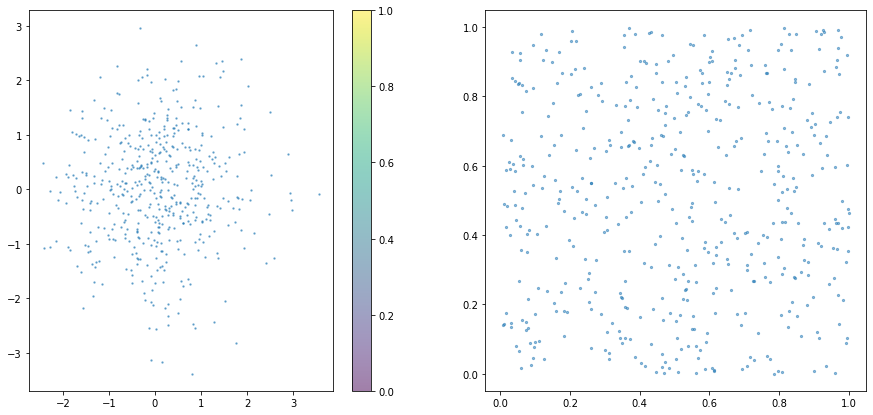

In [38]:
from scipy.stats import norm
n_to_show = 500
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test_reshape[example_idx]
example_labels = y_test[example_idx]

z_points = vae_sv.encoder.predict(example_images)
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
#plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels , alpha=0.5, s=2)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
#plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels, alpha=0.5, s=5)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , alpha=0.5, s=5)


plt.show()

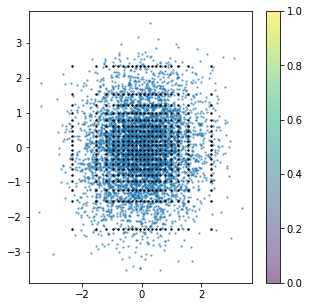

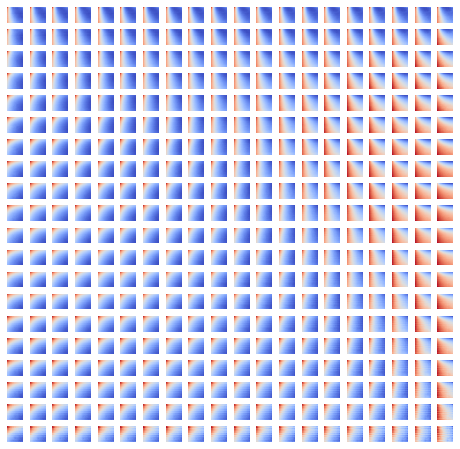

In [39]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test_reshape[example_idx]
example_labels = y_test[example_idx]

z_points = vae_sv.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' #, c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = vae_sv.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=2)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'coolwarm')